## Importing Packages

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import textblob

from textblob import TextBlob
from textblob import Word
#from spellchecker import SpellChecker
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [38]:
# Load the Excel file into a DataFrame
df_SA = pd.read_excel('amazon_review_processed_full.xlsx')

df_SA['ID'] = range(0, len(df_SA))

# Display the DataFrame
df_SA.head(5)

,Review Model,Retailer,Review date,Review name,Review rating,Review title,Review Content,Verified Purchase or not,People_find_helpful,vine or not,...,content_stopwords,title_stopwords,Brand,Full review,ID,Topic0,Topic1,Topic2,Topic3,Topic4
0,Canon Pixma TS6420a,Amazon,2023-08-10,Ernest Birkholz,5,work great,easi instal work great,True,0,False,...,3,0,Canon,work great easi instal work great,0,0.192308,0.192344,0.192308,0.230732,0.192308
1,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunki mid size,slower speed im use old model 8600 new 9015e s...,True,0,False,...,19,0,HP,spunki mid size slower speed im use old model ...,1,0.219016,0.111844,0.293459,0.163706,0.211975
2,Canon PIXMA MG3620,Amazon,2023-03-15,Maria D,4,NaN,i,True,0,False,...,0,0,Canon,i,2,0.200007,0.199993,0.200005,0.200003,0.199992
3,Epson - ET-3830,Amazon,2022-11-17,Ryan H,5,shag know he talk,yup slam upgrad paid littl front equival throw...,True,12,False,...,31,2,Epson,shag know he talk yup slam upgrad paid littl f...,3,0.168985,0.165481,0.239302,0.162820,0.263412
4,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,user friendli,would think someth simpl reconnect wifi would ...,True,0,False,...,71,0,HP,user friendli would think someth simpl reconne...,4,0.261938,0.203476,0.118563,0.275790,0.140233


## Vader Sentiment Scoring on Original Review Content

In [39]:
sia = SentimentIntensityAnalyzer()

In [40]:
#Converting Review Content to string type in order to run Vader Sentiment Analysis
df_SA['Review Content'] = df_SA['Review Content'].astype(str)

### Running the Vader Sentiment Analysis

In [41]:
# Running the polarity score on the entire dataset
res = {}
for i, row in tqdm(df_SA.iterrows(), total=len(df_SA)):
    text = row['Review Content']
    myid = row['ID']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/10209 [00:00<?, ?it/s]

In [42]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'ID'})
vaders = vaders.merge(df_SA, how='left')

In [43]:
vaders[['Review rating','compound']]

,Review rating,compound
0,5,0.6249
1,3,0.8853
2,4,0.0000
3,5,0.5994
4,3,0.7717
...,...,...
10204,5,0.0000
10205,5,0.0000
10206,1,0.0000
10207,1,0.0000


## Plotting VADER results on Original Review Content

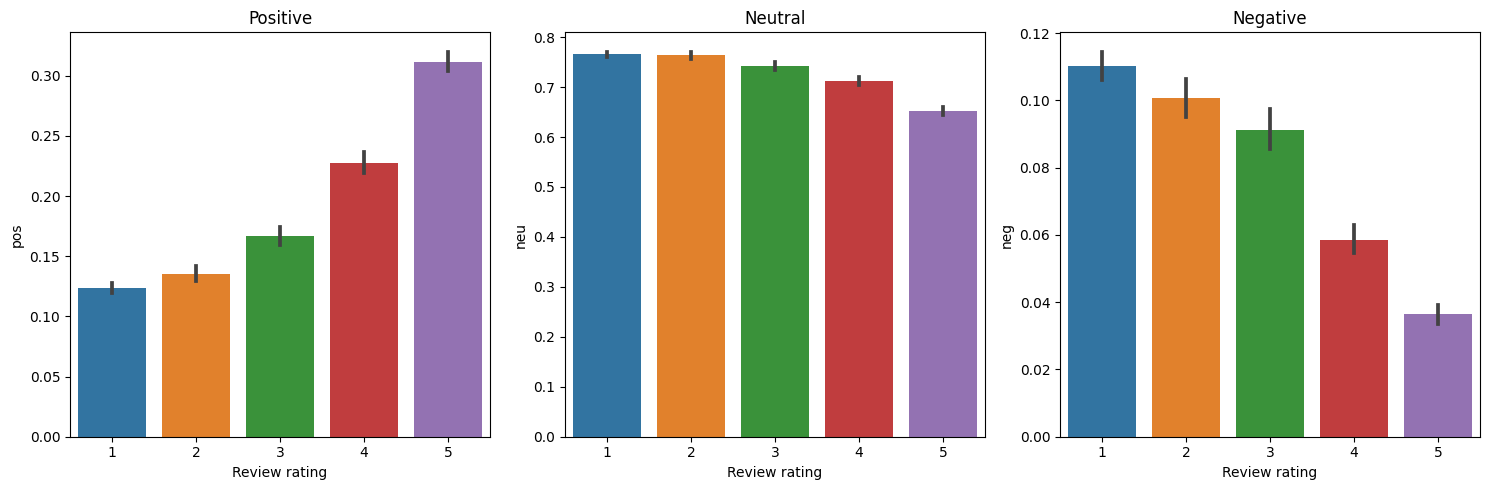

In [44]:
fig, axs = plt.subplots(1,3, figsize = (15,5))
sns.barplot(data=vaders, x='Review rating', y = 'pos', ax=axs[0])
sns.barplot(data=vaders, x='Review rating', y = 'neu', ax=axs[1])
sns.barplot(data=vaders, x='Review rating', y = 'neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

Remarks: As expected, for ratings that are higher, they are more likely to get a higher positive score, while ratings that are lower got a higher negative score.

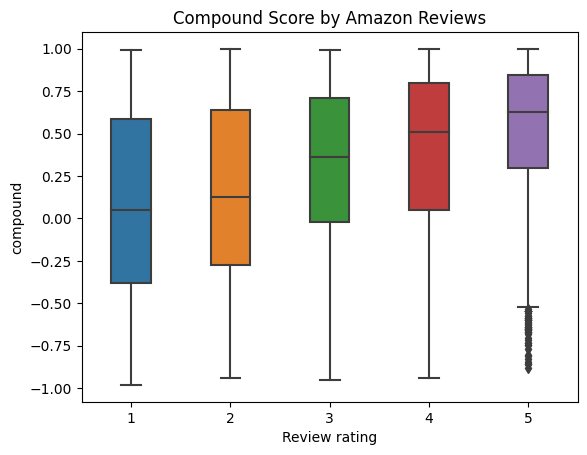

In [45]:
ax = sns.boxplot(x="Review rating", y="compound", data=vaders, width=0.4)
ax.set_title('Compound Score by Amazon Reviews')
plt.show()

The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).

positive sentiment : (compound score >= 0.05) 

neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 

negative sentiment : (compound score <= -0.05)

As we can see, lower ratings have more negative compound scores compared to higher ratings. For the higher ratings, there are a number of negative compound scores which may suggest wrong classification by the model which we will take a closer look in the next section

## Reviewing Examples

In [46]:
vaders = vaders.rename(columns={'Review rating': 'Review_rating'})

In [47]:
vaders.query('Review_rating == 5').sort_values('compound', ascending=False).head(5)

,ID,neg,neu,pos,compound,Review Model,Retailer,Review date,Review name,Review_rating,...,title_avg_word,content_stopwords,title_stopwords,Brand,Full review,Topic0,Topic1,Topic2,Topic3,Topic4
4190,4190,0.014,0.808,0.178,0.9985,Epson - ET-3830,Amazon,2021-12-06,Just Josh,5,...,4.833333,592,2,Epson,great high qualiti econom color scanner add ec...,0.134562,0.041783,0.504710,0.188026,0.130919
3496,3496,0.013,0.819,0.167,0.9971,Epson - XP-6100,Amazon,2019-09-22,Pat Walsh,5,...,3.500000,406,0,Epson,good bad prosrel straight forward setup follow...,0.190066,0.049160,0.355616,0.297338,0.107819
7136,7136,0.009,0.798,0.194,0.9955,HP Smart Tank 7602,Amazon,2022-11-18,Harold McFarland,5,...,3.500000,392,6,HP,good qualiti output easi dealt lot printer bas...,0.182232,0.059032,0.392788,0.227633,0.138316
2603,2603,0.041,0.585,0.373,0.9947,HP DeskJet 2755e,Amazon,2023-08-08,Ava Joy Porter,5,...,5.375000,122,1,HP,great technic skill would help media could loa...,0.119273,0.200730,0.230019,0.264951,0.185027
7351,7351,0.012,0.833,0.155,0.9939,HP OfficeJet Pro 9025e,Amazon,2021-04-23,SoundOff,5,...,3.500000,366,0,HP,hope got compar laserjet screen receiv packag ...,0.114149,0.121661,0.391457,0.257187,0.115546


### Checking if the model works

In [48]:
# Positive sentiment with 5-star review
vaders.query('Review_rating == 5').sort_values('pos', ascending=False)['Original review'].values[0]

'Great!'

In [49]:
# Positive sentiment (based on compound score) with 5-star review
vaders.query('Review_rating == 5').sort_values('compound', ascending=False)['Original review'].values[0]

'Not only will this EcoTank printer save you a ton of money on ink, but it’s easy to setup and all of the features work extremely well.IN THE BOXIn the box you’ll find the printer itself (with lots of blue tape holding everything in place during shipping), a power cable, an instruction packet with a software CD that you won’t use, and 4 bottles of ink.DESIGNThe printer has a fairly standard and compact design. On the back are the ports for power, network, and USB.The lid of the printer opens to reveal the glass scanning surface for the scanner and copier functions.NOTE: This printer does not have an auto document feeder (ADF) even though the comparison chart shows that it does. With this printer you can only scan one sheet of paper at a time and then have to manually change sheets if you want to scan another page.The front of the printer has a color screen, with various buttons around it that you use to navigate through the screens, power the printer on and off, etc.Below the control p

In [50]:
# Negative sentiment with 1-star review
vaders.query('Review_rating == 1').sort_values('neg', ascending=False)['Original review'].values[0]

'very bad'

In [51]:
# Negative sentiment (based on compound score) with 1-star review
vaders.query('Review_rating == 1').sort_values('compound', ascending=True)['Original review'].values[0]

"I purchased this printer new from Amazon. I have never had any issues with printers in the past. My prior printer lasted for about 10-15 years. This one didn't even last two weeks. For the reasons I mention below, I highly recommend avoiding this printer.1. It was tedious to set up. When I received it in the mail, I opened the box and tried to set it up. If you want to use it wirelessly, you need to install an app on your computer. I went through this and it took me about 2-3 hours on two separate occasions for my computer to finally recognize the printer. I was able to print one label.2. The heads were misaligned and were impossible to realign. Upon printing my first label, I noticed the ink was all distorted and I couldn't use it. I researched the issue online and concluded the issue was the printer head alignment. I spent 1-2 hours printing the head alignment page, copying it, and then trying to print one label. It never fixed the misalignment issue, and, over the course of a few d

### Checking if the model produces inaccurate results

In [52]:
# Positive sentiment but with 1-star review
vaders.query('Review_rating == 1').sort_values('pos', ascending=False)['Original review'].values[0:5]

array(['Not a good printer', 'Not a good buy', 'Returned to Amazon',
       'Please be careful with this product.',
       'Epson does not support this product.'], dtype=object)

In [53]:
# Positive sentiment (based on compound score) but with 1-star review
vaders.query('Review_rating == 1').sort_values('compound', ascending=False)['Original review'].values[0]

'This is a review of HP’s approach to this printer.First the light that stays on on the printer. The picture of this product is very deceptive; it does not show just how bright that blue-ish light really is and stays on 24/7/365. If you keep this printer in your room, that light will illuminate almost the entire room at night and the wavelength of the blue light is such that it keeps you from sleeping. Give me one good reason why there is an obnoxiously bright light on a printer that stays on 24/7. Why do I need a loud and bright reminder that the printer is “ready” 24/7? Thats what plugging it in is supposed to do. There is NO way to turn off the extremely bright light. Its almost as though the printer makers want to control your life by being obnoxiously present and having an annoyingly loud way of reminding you day and night that such inconsequential thing as a printer is now this huge thing in your life. There is no way to turn off this light. Plenty of other ways to serve the purp

In [54]:
# Negative sentiment but with 5-star review
vaders.query('Review_rating == 5').sort_values('neg', ascending=False)['Original review'].values[0]

'No complaints'

In [55]:
# Negative sentiment (based on compound score) but with 5-star review
vaders.query('Review_rating == 5').sort_values('compound', ascending=True)['Original review'].values[0]

"This is the worst product I have purchased in a long time...not compatible with my chrome book will not take a page through the feeder to copy can't place a page for copy on screen to copy and now the off on button just flashes...resetting unplugging and restarting nothing works...will be returning this worthless headache hp should be ashamed of the poor performance of this supposed to be copier...."

Some gave positive feedback but gave low ratings, while some gave negative feedback but high ratings. Might be inaccurate ratings on user's end or "troll" feedback

## Checking the split of positive and negative sentiments by Brand

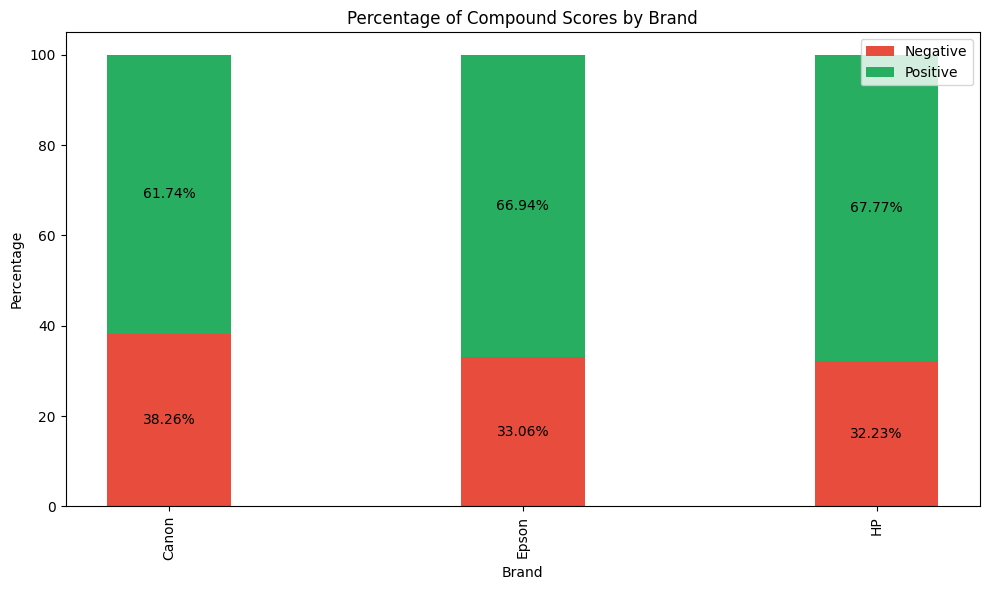

In [56]:
# Group the data by 'Brand' and calculate the percentage of compound scores
# that are less than or equal to 0 and greater than 0
brand_grouped = vaders.groupby('Brand')['compound'].apply(lambda x: (x <= 0).mean() * 100).reset_index(name='Negative %')

# Add a column for positive percentages
brand_grouped['Positive %'] = 100 - brand_grouped['Negative %']

# Sort the DataFrame by 'Negative %' for a better visualization
brand_grouped = brand_grouped.sort_values(by='Negative %', ascending=False)

# Define muted red and green colors
red_color = '#E74C3C'  # Muted red
green_color = '#27AE60'  # Muted green

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(brand_grouped))

plt.bar(index, brand_grouped['Negative %'], bar_width, label='Negative', color=red_color)
plt.bar(index, brand_grouped['Positive %'], bar_width, label='Positive', color=green_color, bottom=brand_grouped['Negative %'])

plt.xlabel('Brand')
plt.ylabel('Percentage')
plt.title('Percentage of Compound Scores by Brand')

# Display percentages on the chart correctly aligned with the bars
for i, (neg_percent, pos_percent) in enumerate(zip(brand_grouped['Negative %'], brand_grouped['Positive %'])):
    ax.text(i, neg_percent / 2, f'{neg_percent:.2f}%', ha='center', va='center', color='black')
    ax.text(i, neg_percent + pos_percent / 2, f'{pos_percent:.2f}%', ha='center', va='center', color='black')

plt.legend()
plt.xticks(index, brand_grouped['Brand'], rotation=90)
plt.tight_layout()
plt.show()


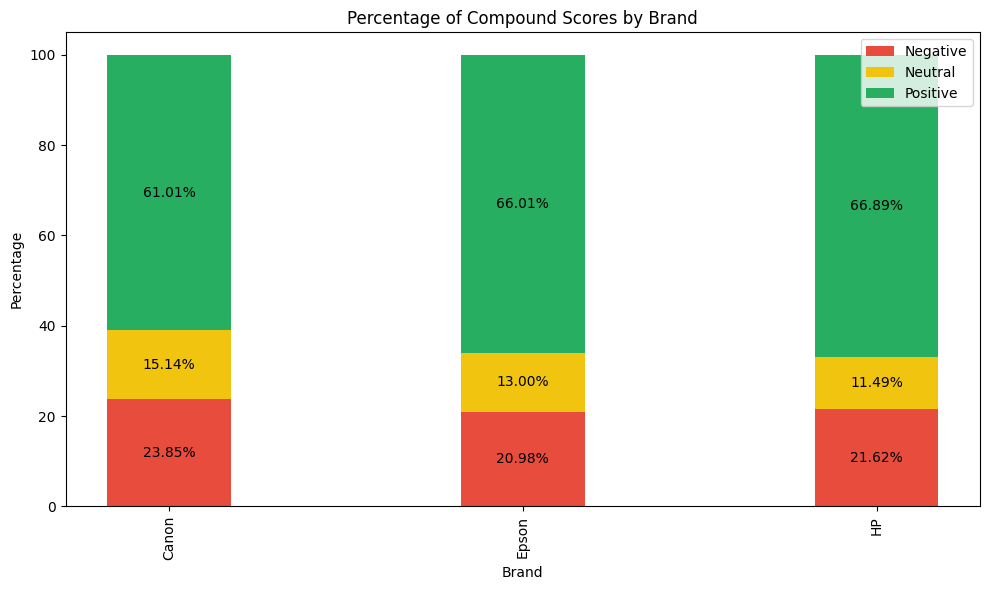

In [63]:
# Define the thresholds for categorization
negative_threshold = -0.05
positive_threshold = 0.05

# Group the data by 'Brand' and calculate the percentage of compound scores in different categories
brand_grouped = vaders.groupby('Brand')['compound'].agg(
    Negative=lambda x: (x < negative_threshold).mean() * 100,
    Neutral=lambda x: ((x >= negative_threshold) & (x <= positive_threshold)).mean() * 100,
    Positive=lambda x: (x > positive_threshold).mean() * 100
).reset_index()

# Sort the DataFrame by 'Brand' for a better visualization
brand_grouped = brand_grouped.sort_values(by='Brand')

# Define muted colors for negative, neutral, and positive
negative_color = '#E74C3C'  # Muted red
neutral_color = '#F1C40F'   # Muted yellow
positive_color = '#27AE60'  # Muted green

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(brand_grouped))

plt.bar(index, brand_grouped['Negative'], bar_width, label='Negative', color=negative_color)
plt.bar(index, brand_grouped['Neutral'], bar_width, label='Neutral', color=neutral_color,
        bottom=brand_grouped['Negative'])
plt.bar(index, brand_grouped['Positive'], bar_width, label='Positive', color=positive_color,
        bottom=brand_grouped['Negative'] + brand_grouped['Neutral'])

plt.xlabel('Brand')
plt.ylabel('Percentage')
plt.title('Percentage of Compound Scores by Brand')

# Display percentages on the chart correctly aligned with the bars
for i, (neg_percent, neu_percent, pos_percent) in enumerate(
        zip(brand_grouped['Negative'], brand_grouped['Neutral'], brand_grouped['Positive'])):
    ax.text(i, neg_percent / 2, f'{neg_percent:.2f}%', ha='center', va='center', color='black')
    ax.text(i, neg_percent + neu_percent / 2, f'{neu_percent:.2f}%', ha='center', va='center', color='black')
    ax.text(i, neg_percent + neu_percent + pos_percent / 2, f'{pos_percent:.2f}%', ha='center', va='center', color='black')

plt.legend()
plt.xticks(index, brand_grouped['Brand'], rotation=90)
plt.tight_layout()
plt.show()

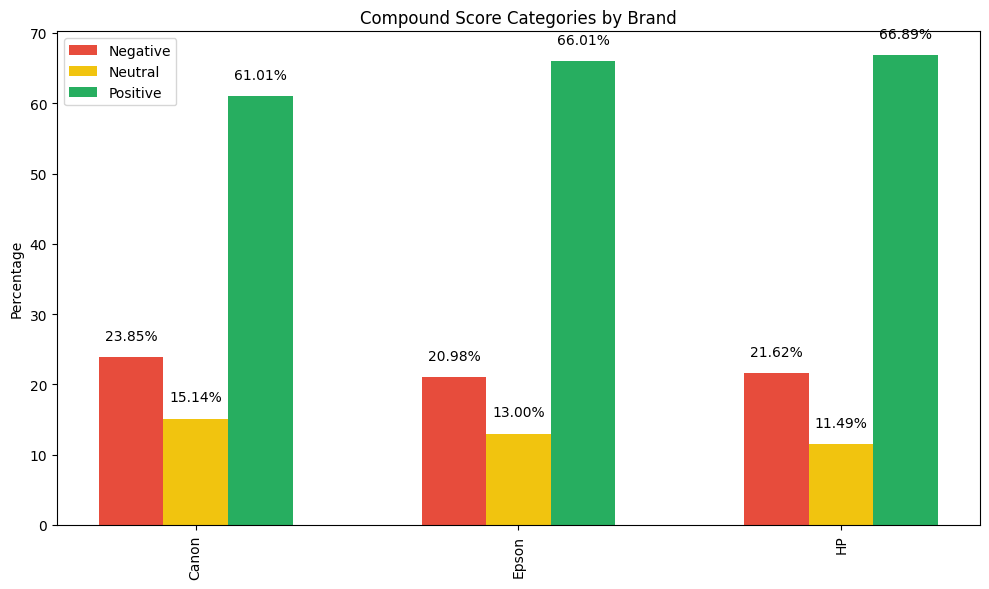

In [78]:
# Define the thresholds for categorization
negative_threshold = -0.05
positive_threshold = 0.05

# Group the data by 'Brand' and calculate the percentage of compound scores in different categories
brand_grouped = vaders.groupby('Brand')['compound'].agg(
    Negative=lambda x: (x < negative_threshold).mean() * 100,
    Neutral=lambda x: ((x >= negative_threshold) & (x <= positive_threshold)).mean() * 100,
    Positive=lambda x: (x > positive_threshold).mean() * 100).reset_index()

# Sort the DataFrame by 'Brand' for a better visualization
brand_grouped = brand_grouped.sort_values(by='Brand')

# Define muted colors for negative, neutral, and positive
negative_color = '#E74C3C'  # Muted red
neutral_color = '#F1C40F'   # Muted yellow
positive_color = '#27AE60'  # Muted green

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set the width of each bar
bar_width = 0.2

# Create an array of x values for each group of bars
index = np.arange(len(brand_grouped))

# Plot bars for each brand and category
ax.bar(index - bar_width, brand_grouped['Negative'], bar_width, label='Negative', color=negative_color)
ax.bar(index, brand_grouped['Neutral'], bar_width, label='Neutral', color=neutral_color)
ax.bar(index + bar_width, brand_grouped['Positive'], bar_width, label='Positive', color=positive_color)

# Set the x-axis ticks and labels
ax.set_xticks(index)
ax.set_xticklabels(brand_grouped['Brand'], rotation=90)

# Set the y-axis label and title
ax.set_ylabel('Percentage')
ax.set_title('Compound Score Categories by Brand')

# Display percentages on the chart above each bar
for i, row in brand_grouped.iterrows():
    ax.text(i - bar_width, row['Negative'] + 2, f'{row["Negative"]:.2f}%', ha='center', va='bottom', color='black')
    ax.text(i, row['Neutral'] + 2, f'{row["Neutral"]:.2f}%', ha='center', va='bottom', color='black')
    ax.text(i + bar_width, row['Positive'] + 2, f'{row["Positive"]:.2f}%', ha='center', va='bottom', color='black')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

HP seems to have the highest percentage of positive sentiments, followed by Epson and then Canon.
For negative sentiments, HP ranks in the middle, with Canon having the most number and Epson having the least.

In [80]:
vaders.head(5)

,ID,neg,neu,pos,compound,Review Model,Retailer,Review date,Review name,Review_rating,...,title_avg_word,content_stopwords,title_stopwords,Brand,Full review,Topic0,Topic1,Topic2,Topic3,Topic4
0,0,0.000,0.423,0.577,0.6249,Canon Pixma TS6420a,Amazon,2023-08-10,Ernest Birkholz,5,...,5.000000,3,0,Canon,work great easi instal work great,0.192308,0.192344,0.192308,0.230732,0.192308
1,1,0.000,0.774,0.226,0.8853,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,...,5.000000,19,0,HP,spunki mid size slower speed im use old model ...,0.219016,0.111844,0.293459,0.163706,0.211975
2,2,0.000,0.000,0.000,0.0000,Canon PIXMA MG3620,Amazon,2023-03-15,Maria D,4,...,5.500000,0,0,Canon,i,0.200007,0.199993,0.200005,0.200003,0.199992
3,3,0.144,0.657,0.199,0.5994,Epson - ET-3830,Amazon,2022-11-17,Ryan H,5,...,4.833333,31,2,Epson,shag know he talk yup slam upgrad paid littl f...,0.168985,0.165481,0.239302,0.162820,0.263412
4,4,0.104,0.734,0.162,0.7717,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,...,5.000000,71,0,HP,user friendli would think someth simpl reconne...,0.261938,0.203476,0.118563,0.275790,0.140233


## Analysizing Sentiments by Topic

In [84]:
vaders["DomTopic"] = vaders.iloc[:,[31, 32, 33, 34, 35]].idxmax(axis=1)

Topics are as follows: 

- 0: issues, jams
- 1: tech support, returns
- 2: print quality
- 3: setup, connecting
- 4: catridge replacement, subscription

In [86]:
# Define the thresholds for categorization
negative_threshold = -0.05
positive_threshold = 0.05

# Create a new column 'Sentiment' based on compound score
vaders['Sentiment'] = vaders['compound'].apply(lambda x: 'Positive' if x > positive_threshold else ('Negative' if x < negative_threshold else 'Neutral'))

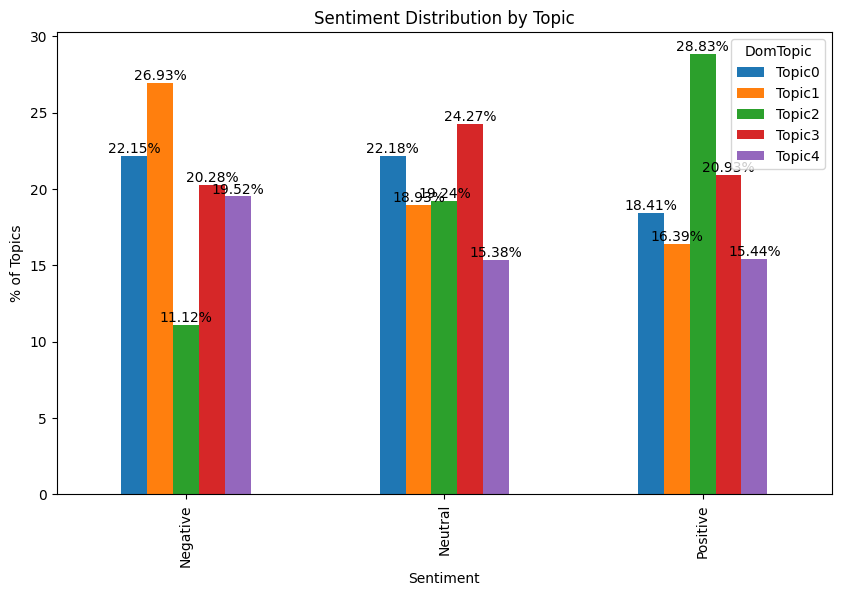

In [92]:
# Adding a new column Count
vaders['Count'] = 1  # Set 'Count' to 1 for each row

# Group the data by 'Sentiment' and 'Dom Topic' and calculate the percentage
topic_grouped = vaders.groupby(['Sentiment', 'DomTopic'])['Count'].sum().unstack(level=1)
topic_grouped = topic_grouped.div(topic_grouped.sum(axis=1), axis=0) * 100

# Create the bar chart
ax = topic_grouped.plot(kind='bar', figsize=(10, 6))

# Set labels and title
plt.xlabel('Sentiment')
plt.ylabel('% of Topics')
plt.title('Sentiment Distribution by Topic')

# Display percentages above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

# Show the plot
plt.show()

Here's a summary of the observations from the sentiments by each topic.

Topic 1 (Tech support & returns) have the highest proportion of negative sentiments, and at the same time it has the second lowest positive sentiments. Seems like customers may face poor service on general tech support as well as performing returns.

Topic 2 (Print quality) has the highest proportion of positive sentiments while at the same time having the least proportion of negative sentiments. There seems to be a good appreciation of print quality across the board.

### Analyzing the sentiments by topic for each brand

Now that we have a general overview of the sentiments of each topic, we'll dive deeper into understanding what are the sentiments of each topic for each brand to have a comparison.

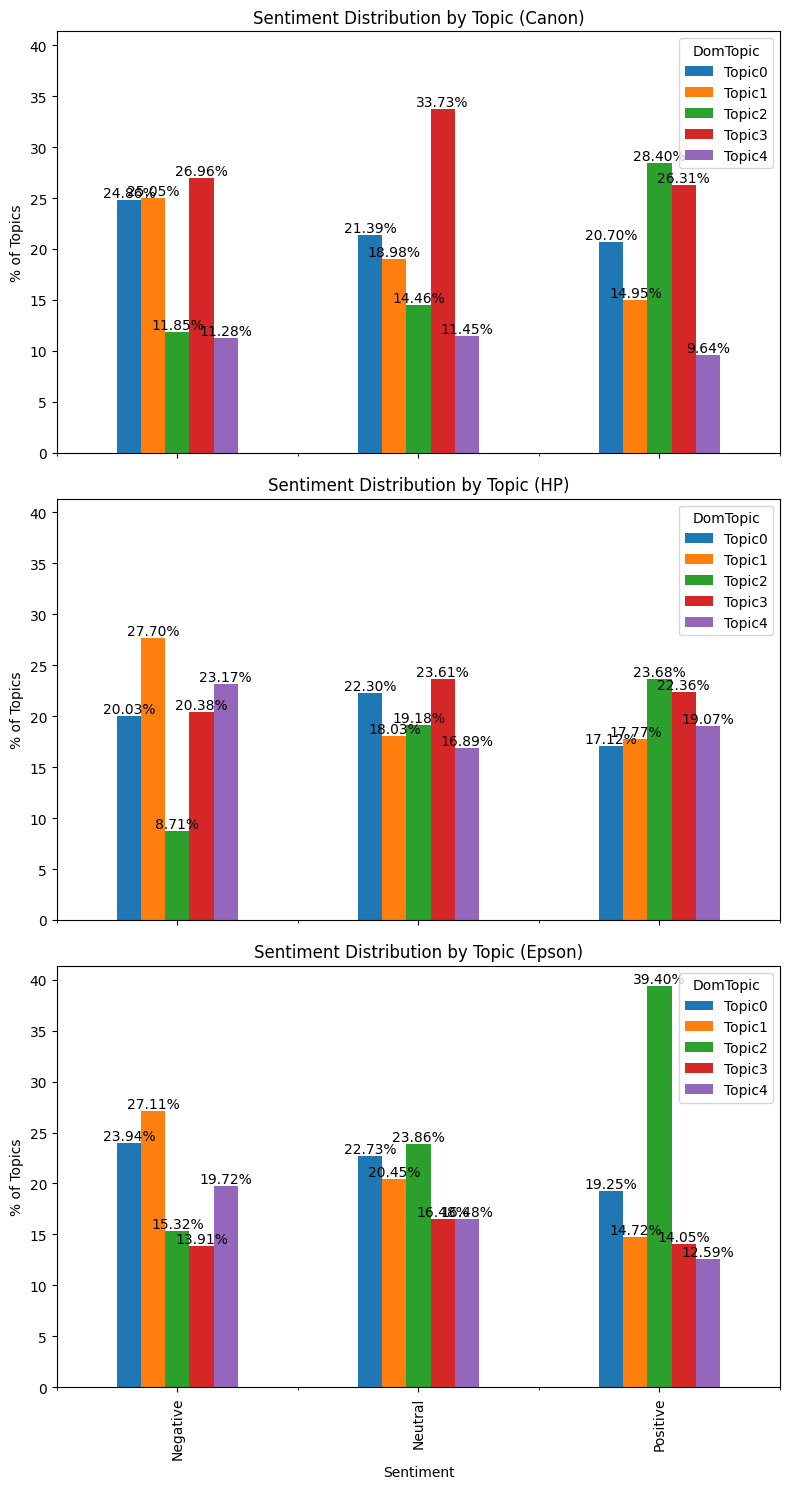

In [97]:
# Create a new column 'Count'
vaders['Count'] = 1  # Set 'Count' to 1 for each row

# Get unique brands
brands = vaders['Brand'].unique()

# Create a 3x1 grid for three subplots with separate y-axes
fig, axes = plt.subplots(len(brands), 1, figsize=(8, 15), sharex=True, sharey=True)

for i, brand in enumerate(brands):
    brand_data = vaders[vaders['Brand'] == brand]
    brand_grouped = brand_data.groupby(['Sentiment', 'DomTopic'])['Count'].sum().unstack(level=1)

    # Calculate the percentage
    brand_grouped = brand_grouped.div(brand_grouped.sum(axis=1), axis=0) * 100

    ax = brand_grouped.plot(kind='bar', ax=axes[i])

    # Set labels and title for each subplot
    ax.set_xlabel('Sentiment')
    ax.set_ylabel('% of Topics')
    ax.set_title(f'Sentiment Distribution by Topic ({brand})')

    # Display percentages above each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.tight_layout()  # To prevent overlapping of subplots
plt.show()

In [149]:
# Showing a sample of positive sentiment for HP topic 2
vaders[(vaders['DomTopic'] == 'Topic2') & (vaders['Brand'] == 'HP')].sort_values(by='compound', ascending=False).iloc[22]['Original review']

'I got this to be able to print water slides with an inkjet printer as I already have a laser printer that works great. Quality wise this is a good printer. Depending on what program you use the print quality is good. I wouldn’t say it’s professional portrait quality but for my images they turn out good. Printing pages is also quick. Setup to WiFi took me a few minutes but wasn’t terrible. This is great for a home office having the copy, fax, and scan option as well. This printer comes with a one year warranty but if you sign up for the free six month ink account then you activate another year. This comes up on my iphone as an option to print when I want to print a document online making it super convenient for me.'

In [150]:
# Showing a sample of negative sentiment for HP topic 2
vaders[(vaders['DomTopic'] == 'Topic1') & (vaders['Brand'] == 'HP')].sort_values(by='compound', ascending=True).iloc[1]['Original review']

"Everything about this experience has been an exercise in anger management. The app is utterly useless for anything other than selling you more ink and paper, nothing is intuitive or user friendly, and the amount of failed prints I've had is unbelievable! Literally every print job I've done has had at least 3 failures. Over 70 pages of failed prints in a month! AND FAILED PRINTS COUNT AGAINST YOUR PAGE COUNT!I'll never buy another HP product and I have nothing but buyer's remorse with this one!"

The sentiments for HP seems to be quite evenly distributed across the board. The highest proportion of negative sentiments are towards Topic 1 (tech support and returns), which was the same as the general overview, while the lowest proportion of negative sentiments are towards Topic 2 (print quality). For positive sentiments, Topic 2 has the highest but it is not too far off from Topic 3 (setup and connecting). This may suggest that HP is an all-rounder, and generally people have good points to say about each of the printer's functions. However, this could also mean that HP does not have a USP (unique selling point).

The sentiments for Canon are mixed. It has 3 main topics that dominates the negative sentiments, Topics 0 (issues, jams), 1 (tech support and returns), and 3 (setup and connecting). For positive sentiments, Topics 2 and 3 are the leading topics. Topic 3 seems to have differing opinions, could either be printer related or users who may not be familiar with setting up connection for the first time (user manual not detailed or easy to understand).

The sentiments for Epson are generally even, with Topics 0 and 1 being dominant in the negative sentiments. For positive sentiments, Topic 2 leads way ahead, suggesting that print quality is the standout feature for Epson printers.

## Analyzing sentiments by price points

In [98]:
# Define the price point ranges and labels
price_ranges = [0, 100, 250, 550]
price_labels = ['Budget', 'Mid-range', 'High-end']

# Create a new column 'Price Category' based on the 'list price' column
vaders['PriceCategory'] = pd.cut(vaders['list price'], bins=price_ranges, labels=price_labels)


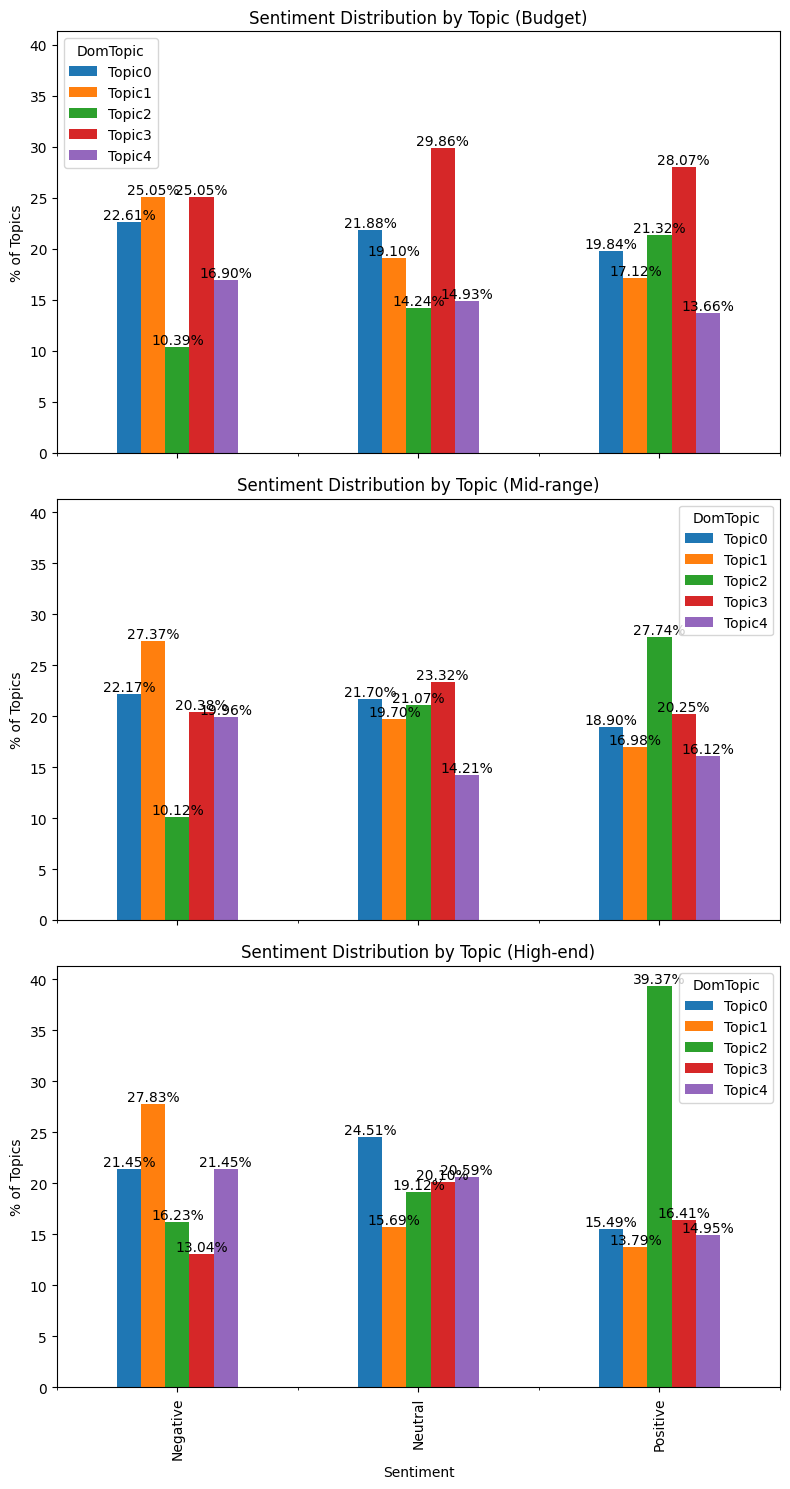

In [112]:
# Define the price point ranges and labels
price_ranges = [0, 100, 250, 550]
price_labels = ['Budget', 'Mid-range', 'High-end']

# Create a new column 'Price Category' based on the 'list price' column with specified order
vaders['PriceCategory'] = pd.cut(vaders['list price'], bins=price_ranges, labels=price_labels, ordered=True, include_lowest=True)

# Get unique price categories in the desired order
price_categories = ['Budget', 'Mid-range', 'High-end']

# Create a 3x1 grid for three subplots with separate y-axes
fig, axes = plt.subplots(len(price_categories), 1, figsize=(8, 15), sharex=True, sharey=True)

for category in price_categories:
    category_data = vaders[vaders['PriceCategory'] == category]
    category_grouped = category_data.groupby(['Sentiment', 'DomTopic'])['Count'].sum().unstack(level=1)

    # Calculate the percentage
    category_grouped = category_grouped.div(category_grouped.sum(axis=1), axis=0) * 100

    ax = category_grouped.plot(kind='bar', ax=axes[price_categories.index(category)])

    # Set labels and title for each subplot
    ax.set_xlabel('Sentiment')
    ax.set_ylabel('% of Topics')
    ax.set_title(f'Sentiment Distribution by Topic ({category})')

    # Display percentages above each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.tight_layout()  # To prevent overlapping of subplots
plt.show()

## Analyzing sentiments by model (HP)

In [118]:
# List of the four main HP models (partial names)
main_models = ['DeskJet', 'ENVY', 'OfficeJet', 'Smart Tank']

# Filter the DataFrame based on partial model names
filtered_data = vaders[vaders['Review Model'].str.contains('|'.join(main_models))]

# Group the filtered data by 'Review model' and 'PriceCategory' and count
model_price_counts = filtered_data.groupby(['Review Model', 'PriceCategory']).size().unstack(fill_value=0)

# Display the count of price categories for each model
print(model_price_counts)

PriceCategory           Budget  Mid-range  High-end
Review Model                                       
HP DeskJet 2755e             0        796         0
HP DeskJet 4155e           569          0         0
HP ENVY 6055e                0        566         0
HP ENVY 6455e                0        472         0
HP ENVY Inspire 7255e        0        283         0
HP ENVY Inspire 7955e        0        354         0
HP OfficeJet Pro 8025e       0        580         0
HP OfficeJet Pro 8034e       0          0        88
HP OfficeJet Pro 9015e       0          0       526
HP OfficeJet Pro 9025e       0          0       293
HP Smart Tank 5101           0        203         0
HP Smart Tank 6001           0        228         0
HP Smart Tank 7001           0        111         0
HP Smart Tank 7301           0          0       143
HP Smart Tank 7602           0          0        97


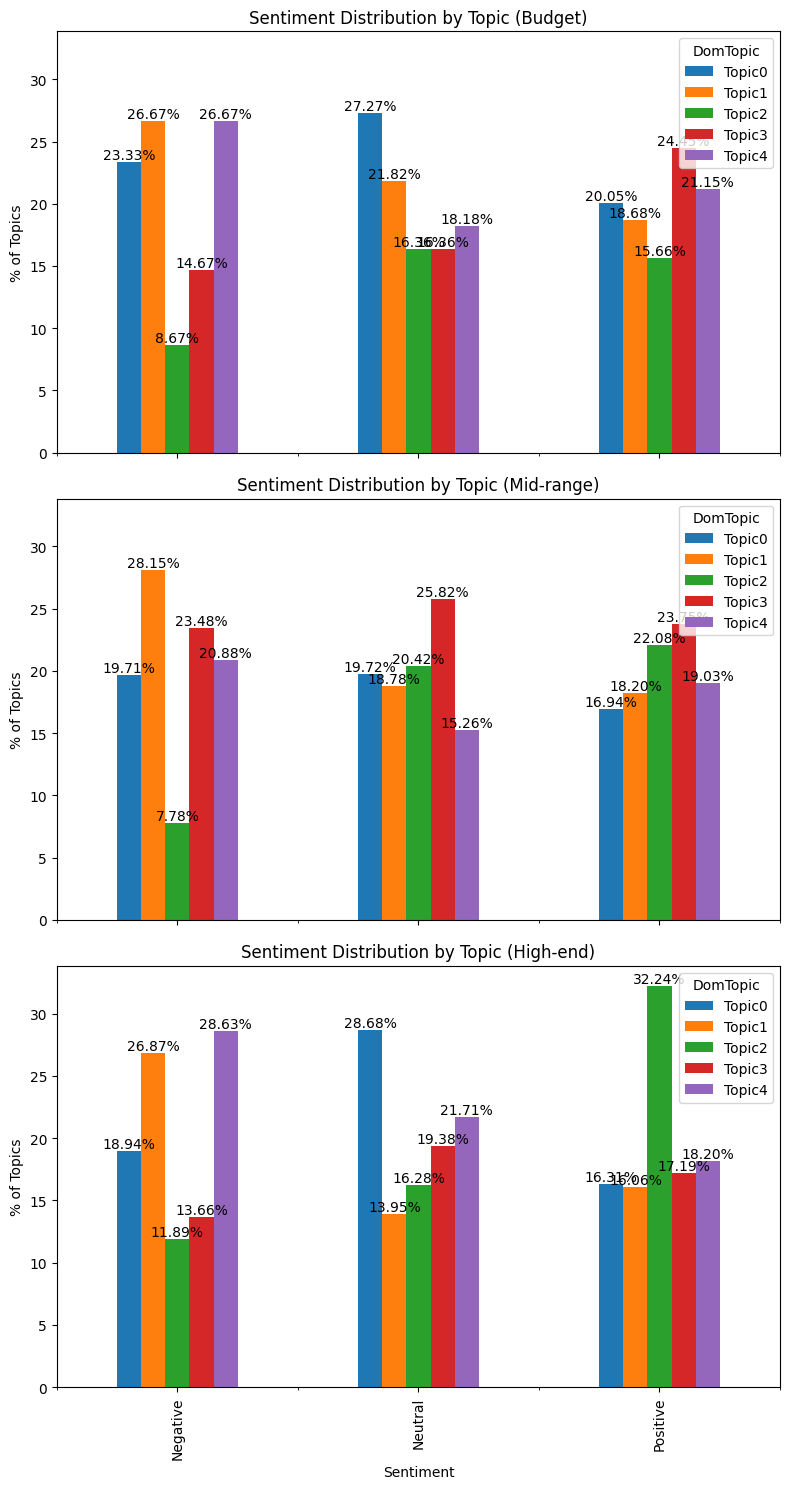

In [120]:
# Filter the data for Brand == 'HP'
hp_data = vaders[vaders['Brand'] == 'HP'].copy()

# Define the price point ranges and labels
price_ranges = [0, 100, 250, 550]
price_labels = ['Budget', 'Mid-range', 'High-end']

# Create a new column 'Price Category' based on the 'list price' column with specified order
hp_data['PriceCategory'] = pd.cut(hp_data['list price'], bins=price_ranges, labels=price_labels, ordered=True, include_lowest=True)

# Get unique price categories in the desired order
price_categories = ['Budget', 'Mid-range', 'High-end']

# Create a 3x1 grid for three subplots with separate y-axes
fig, axes = plt.subplots(len(price_categories), 1, figsize=(8, 15), sharex=True, sharey=True)

for category in price_categories:
    category_data = hp_data[hp_data['PriceCategory'] == category]
    category_grouped = category_data.groupby(['Sentiment', 'DomTopic'])['Count'].sum().unstack(level=1)

    # Calculate the percentage
    category_grouped = category_grouped.div(category_grouped.sum(axis=1), axis=0) * 100

    ax = category_grouped.plot(kind='bar', ax=axes[price_categories.index(category)])

    # Set labels and title for each subplot
    ax.set_xlabel('Sentiment')
    ax.set_ylabel('% of Topics')
    ax.set_title(f'Sentiment Distribution by Topic ({category})')

    # Display percentages above each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.tight_layout()  # To prevent overlapping of subplots
plt.show()